# Part 1 - retrieving data

In this part we will retrieve the data and create a document corpus. Each file will be loaded as a separate document from the documentation archive. The content is categorized in subfolders. 

Documentation is written in [AsciiDoc](http://asciidoc.org/). Each product is documented in a separate folder. The folder has several versions of the documentation and each version has the following structure:
  - _attachments folder
  - _images folder
  - content .adoc files

Only .adoc files will get retrieved while images, attachments and other configuration files will be ommitted.

In [443]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import numpy as np

In [2]:
def create_dataframe(dir_path):
    corpus = []
    for root, dirs, files in os.walk(dir_path):
        for file_name in files:
            file_n = file_name.split('.')[0]
            if '.' not in file_name:
                continue
            file_ext = file_name.split('.')[1]
            if file_ext != 'adoc' or file_n == '_toc':
                continue
            full_file_path = os.path.join(root, file_name)
            with open(full_file_path) as file:
                content = file.read()
                corpus.append({"file":full_file_path, "text":content})
    return pd.DataFrame(corpus)
                

In [2]:
# by default load the file, otherwise create dataframe - change True -> False
if True:
    corpus_df = pd.read_csv('./df_flagged.csv') 
else:
    corpus_df = create_dataframe(os.path.join(os.getcwd(), 'mulesoft-docs-master'))

In [3]:
corpus_df.head()

,Unnamed: 0,file,text,stripped_txt,txt_3gram,has_support_case
0,0,/home/kliton/Documents/Springboard/Capstone2/m...,= Glossary\n:keywords: glossary\n\nThe followi...,glossary keywords glossary the following ...,glossary keyword glossary follow glossary hel...,0
1,1,/home/kliton/Documents/Springboard/Capstone2/m...,"= MuleSoft Documentation\n:keywords: platform,...","mulesoft documentation keywords platform, ...",mulesoft documentation keyword platform arm r...,0
2,2,/home/kliton/Documents/Springboard/Capstone2/m...,= To Set the API URL\n\nOn the API version det...,to set the api url on the api version detai...,set api url api version_page configure inboun...,0
3,3,/home/kliton/Documents/Springboard/Capstone2/m...,"= To Disable, Edit, or Remove a Policy\n\n. In...","to disable, edit, or remove a policy . in a...",disable edit remove policy. anypoint_platform...,0
4,4,/home/kliton/Documents/Springboard/Capstone2/m...,"= IP Blacklist\n:keywords: IP, blacklist, vali...","ip blacklist keywords ip, blacklist, valid...",ip blacklist keyword ip blacklist validation ...,0


The number of text files in the corpus is:

In [4]:
len(corpus_df)

1187

Let's have a look at the number of documents per product. This will correspond to the number of files in each folder.

In [6]:
docs_per_product = corpus_df.file.apply(lambda x: x.split("/")[7] if len(x.split("/")) > 8 else "").value_counts()

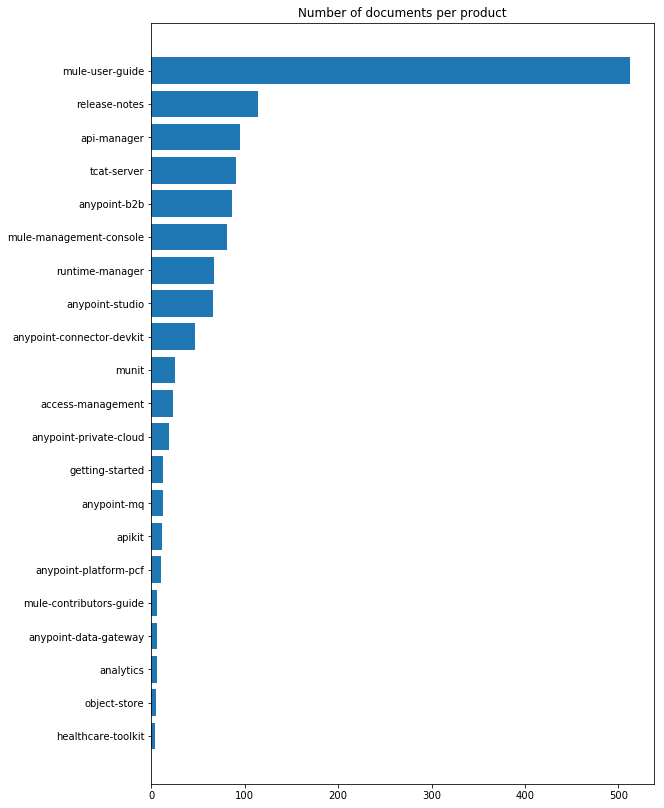

In [7]:
fig = plt.figure( figsize=(9,14))
axes = fig.add_subplot(111, title = "Number of documents per product")
plt.barh(np.arange(len(docs_per_product.index) -1), docs_per_product.values[-2::-1], 
         tick_label = docs_per_product.index[-2::-1]);

Mule Runtime is the product with the most files. This is the core product of the company. While Release Notes takes the second place on the number of documents per product, it should not be included in the corpus. Release notes document each new version of the product including improvements, known issues, etc. For the purpose of this project the presence of Release notes is not required and it can bias some of the results. 

In [8]:
corpus_df = corpus_df[corpus_df.file.apply(lambda x: x.split("/")[7] if len(x.split("/")) > 8 else "") != 'release-notes']

Now, let's have a look at the remaining number of documents:

In [9]:
print("Number of documents: ", len(corpus_df))

Number of documents:  1187


The text should be processed. We should remove the following text elements:
    - asciidoc format tags
    - remove web links
    - remove code snippets (mostly xml configurations, probably some java code)
    - remove spaces and new lines (\n)
    - treat all the tokens that include period marks (.) in a special way by replacing those to underscores i.e. org.mulesoft.module to org_mulesoft_module, 3.8.1 to 3_8_1, etc. Those are meaningful tokens.
    
A document looks like the following:

In [10]:
corpus_df.text.iloc[301]

'= SAP Connector Troubleshooting\n:keywords: sap, connector, troubleshooting\n:imagesdir: ./_images\n\nThis page contains common troubleshooting suggestions for the link:/mule-user-guide/v/3.8/mulesoft-enterprise-java-connector-for-sap-reference[SAP Connector].\n\n\n[[checking-log-files]]\n== Checking Log Files\n\nMule stores log files (on a per application basis) in the `$MULE_HOME\\logs` directory:\n\n* `mule.log` - default Mule log file.\n* `mule-app-YOUR_APP_NAME.log` - per application log file.\n\n[[enabling-jco-trace]]\n== Enabling JCo Trace\n\nJCo Trace can be enabled from outside Mule and accepts the following Java startup environment properties:\n\n* `-Djco.trace_level=N` (where 0 \\<= N \\<= 10, with 10 = most detailed trace)\n* `-Djco.trace_path=<PATH>` (optional)\n\nTo enable traces at the connector level, perform the following steps:\n\n. Set the attribute `jcoTrace` to `true` or provide the extended JCo property `jco.client.trace` or `jco.server.trace` with value `1`.\n. 

To handle the preprocessing task we create this procedure:

In [11]:
def processText(str_input):
    
    # regex to remove links
    link_comp = re.compile(r"link:.*?\[(\w*)\]*?")
    
    # regex to remove images
    image_comp =re.compile(r"image:.*?\[(\w([\s.-])*)*\]*?")
    
    image_regex = r"image:.*\[((\w(\s\S)*)*)\]"
    
    # regex to remove code
    codeblock_comp= re.compile(r"\n\[(\w[,-.\s]*)+\]\n----.*?----", flags=re.S)
    
    # regex to remove other asciidoc tags
    asciid_tags = re.compile(r"(\[\[\S*?\]\])|(\[\S*?\])", flags=re.S)
    
    str_without_links = "".join(link_comp.split(str_input))
    str_without_images = image_comp.subn(" ", str_without_links)[0]
    str_without_code = codeblock_comp.subn(" ", str_without_images)[0]
    str_without_tags = asciid_tags.subn(" ", str_without_code)[0]
    str_linkexc = re.sub(r"(([a-zA-z0-9\-]+)[\.])+([a-zA-z0-9\-]+)", 
                         lambda x: x.group().replace(".", "_"),
                        str_without_tags)
    
    # regex to remove all the other punctuations
    punct_comp = re.compile(r"[\:\+\|=\[\]®`<>\/\(\)\{\}\*\n\t\$\"\\]")
    str_linkexc = punct_comp.subn(" ", str_linkexc)[0]
    
    return str_linkexc.lower()
    

Add another column in the corpus and apply the text processing procedure to clean the text:

In [12]:
corpus_df.loc[:, "stripped_txt"] = corpus_df.text.apply(processText)

The processed text looks like this:

In [13]:
processText(corpus_df.text.iloc[301])

"  sap connector troubleshooting  keywords  sap, connector, troubleshooting  imagesdir  . _images  this page contains common troubleshooting suggestions for the sap connector .        checking log files  mule stores log files  on a per application basis  in the   mule_home logs  directory      mule_log  - default mule log file.    mule-app-your_app_name_log  - per application log file.       enabling jco trace  jco trace can be enabled from outside mule and accepts the following java startup environment properties      -djco_trace_level n   where 0     n     10, with 10   most detailed trace     -djco_trace_path  path    optional   to enable traces at the connector level, perform the following steps   . set the attribute  jcotrace  to  true  or provide the extended jco property  jco_client_trace  or  jco_server_trace  with value  1 . . provide a value for  -djco_trace_level n  at mule startup.  jco offers trace levels from 0 to 10 . the amount of traced data increases with the chosen t

Now, we can proceed with some more text analysis. 

In [445]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

Create a bag-of-words representation by using CountVectorizer. To explore we define a limit of 1000 features

In [446]:
word_vectorizer = CountVectorizer( stop_words='english', min_df=2, max_df=0.95, max_features=1000)

In [447]:
bow_1gram = word_vectorizer.fit_transform(corpus_df.stripped_txt)

The bag of words is a matrix consisting of document index in the rows and feature (word) index in the columns. The shape of the matrix is:

In [448]:
bow_1gram.shape

(1176, 1000)

As expected, the row count matches the number of documents and the columns count matches the number of features.

Let's have a quick look at the vocabulary:

In [18]:
word_vectorizer.get_feature_names()[20:40]

['active',
 'actual',
 'add',
 'added',
 'adding',
 'addition',
 'additional',
 'address',
 'addresses',
 'adds',
 'admin',
 'administration',
 'administrator',
 'advanced',
 'agent',
 'ajax',
 'alert',
 'alerts',
 'allow',
 'allowed']

There are a lot of the same words listed both in singular and plural for nouns and also other modifications for verbs (verb tense, gerunds, etc.). It would be best to stem or lemmatize the words.

With the above information we can plot the word frequency proportion in the documents:

In [449]:
x, counts = np.unique((bow_1gram > 0).sum(0).tolist()[0], return_counts=True)

In [462]:
[y for y in zip(x, counts)]

[(3, 1),
 (4, 1),
 (5, 2),
 (6, 1),
 (7, 1),
 (9, 2),
 (11, 4),
 (12, 1),
 (14, 4),
 (15, 1),
 (16, 3),
 (17, 3),
 (18, 2),
 (19, 1),
 (20, 1),
 (21, 4),
 (22, 4),
 (23, 1),
 (24, 2),
 (25, 2),
 (26, 2),
 (27, 2),
 (28, 7),
 (29, 3),
 (30, 6),
 (31, 2),
 (32, 4),
 (33, 5),
 (34, 2),
 (35, 3),
 (36, 2),
 (37, 8),
 (38, 2),
 (39, 8),
 (40, 5),
 (41, 2),
 (42, 7),
 (43, 3),
 (44, 6),
 (45, 5),
 (46, 7),
 (47, 4),
 (48, 2),
 (49, 2),
 (50, 3),
 (51, 10),
 (52, 4),
 (53, 7),
 (54, 6),
 (55, 5),
 (56, 4),
 (57, 3),
 (58, 6),
 (59, 7),
 (60, 8),
 (61, 5),
 (62, 5),
 (63, 7),
 (64, 4),
 (65, 8),
 (66, 7),
 (67, 8),
 (68, 8),
 (69, 3),
 (70, 5),
 (71, 5),
 (72, 7),
 (73, 10),
 (74, 4),
 (75, 8),
 (76, 9),
 (77, 5),
 (78, 10),
 (79, 7),
 (80, 6),
 (81, 3),
 (82, 7),
 (83, 9),
 (84, 9),
 (85, 5),
 (86, 8),
 (87, 7),
 (88, 13),
 (89, 6),
 (90, 5),
 (91, 7),
 (92, 5),
 (93, 5),
 (94, 4),
 (95, 7),
 (96, 4),
 (97, 3),
 (98, 5),
 (99, 6),
 (100, 1),
 (101, 3),
 (102, 7),
 (103, 2),
 (104, 7),
 (105, 

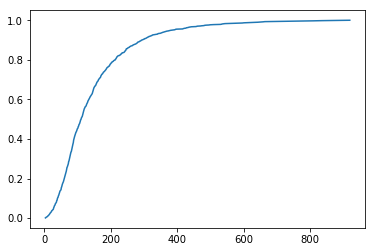

In [20]:
plt.plot(x, counts.cumsum()/counts.sum());

The distribution of word frequencies in the document is displayed above. In the x-axis is the number of documents that a word appears in. On the y-axis is displayed the percentage of words that are part of x or less documents. For this example we considered only 1000 features (words). This test should be conducted on the whole dataset. 

With the information that we have retrieved so far we can visualize the most frequent words in all documents in a word cloud:

In [21]:
from wordcloud import WordCloud

In [22]:
wc = WordCloud().generate_from_frequencies(zip(word_vectorizer.get_feature_names(), bow_1gram.sum(axis=0).tolist()[0]) )

(-0.5, 399.5, 199.5, -0.5)

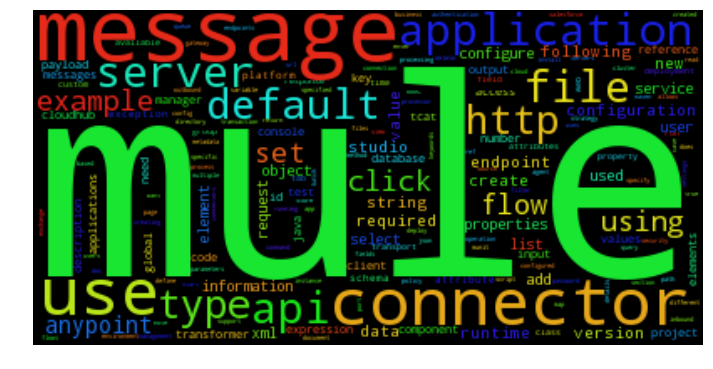

In [23]:
plt.figure(figsize=(12, 9))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

In [24]:
from nltk.stem.snowball import SnowballStemmer

In [25]:
import nltk
#nltk.download()

In [26]:
eng_stemmer = SnowballStemmer("english", ignore_stopwords=True)

In [12]:
from spacy.en import English
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
import string
parser = English()

STOPLIST = set(stopwords.words('english') + ["n't", "'s", "'m", "ca", "use", "glossary", "keyword", "mule"] + list(ENGLISH_STOP_WORDS))
# List of symbols we don't care about
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-----", "--", "---", "----", "...", "“", "”", "'ve", "\"", "="]

def tokenizeText(sample):

    # get the tokens using spaCy
    tokens = parser(sample)

    # lemmatize
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas

    # stoplist the tokens
    tokens = [tok for tok in tokens if tok not in STOPLIST]

    # stoplist symbols
    tokens = [tok for tok in tokens if tok not in SYMBOLS]

    # remove large strings of whitespace
    while "" in tokens:
        tokens.remove("")
    while " " in tokens:
        tokens.remove(" ")
    while "\n" in tokens:
        tokens.remove("\n")
    while "\n\n" in tokens:
        tokens.remove("\n\n")

    return tokens

In [569]:
word_vectorizer_spacy = CountVectorizer(tokenizer=tokenizeText, min_df=3, max_df=0.95)
bow_1gram_spacy = word_vectorizer_spacy.fit_transform(corpus_df.stripped_txt)

In [570]:
wc2 = WordCloud().generate_from_frequencies(zip(word_vectorizer_spacy.get_feature_names(), bow_1gram_spacy.sum(axis=0).tolist()[0]) )

(-0.5, 399.5, 199.5, -0.5)

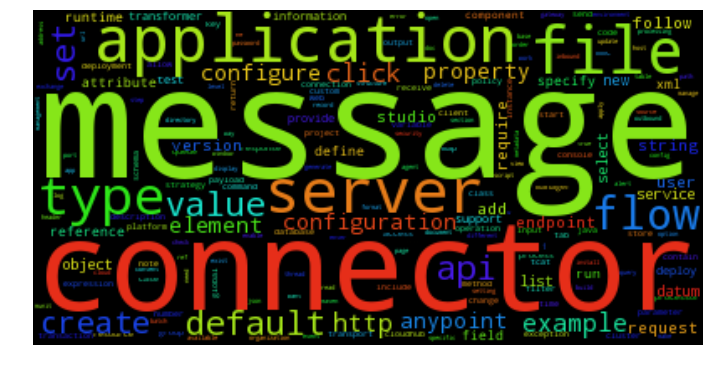

In [571]:
plt.figure(figsize=(12, 9))
plt.imshow(wc2, interpolation='bilinear')
plt.axis("off")

### Distribution of tokenized words in documents

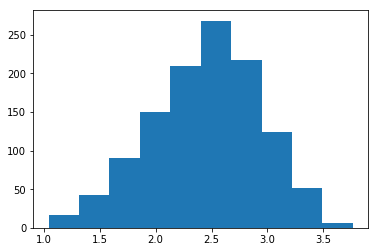

In [498]:
plt.hist(np.log10([len(x.split()) for x in corpus_df.txt_3gram]), label="Distribution of tokenized words in documents");

The range of document lengths varies from 10 words to 1000+ words. We have removed documents with less than 10 words.

In [5]:
# create a new field in dataframe that corresponds to document lengths
corpus_df.loc[:, 'txt_length'] = corpus_df.txt_3gram.apply(lambda x: len(x.split() ) )

In [6]:
# remove documents with less than 10 words
corpus_df  = corpus_df[corpus_df.txt_length > 10]

In [7]:
corpus_df.columns

Index(['Unnamed: 0', 'file', 'text', 'stripped_txt', 'txt_3gram',
       'has_support_case', 'txt_length'],
      dtype='object')

In [31]:
# Another way to tokenize text and transform to tfidf
# TfidfVectorizer(tokenizer=tokenizeText, min_df=2, max_df=0.95)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.95, max_features=None, min_df=2,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenizeText at 0x7fb12abf7950>, use_idf=True,
        vocabulary=None)

### Create text corpus with Gensim

In [8]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.models.word2vec import LineSentence
import itertools as it

In [9]:
# grep all sentences from a series slice
def documentGenerator(fromSeries, start=None, end=None):
    for doc in fromSeries.iloc[start:end]:
        doc_sen = [tokenizeText(senten) for senten in doc.split('.')]
        yield doc_sen

In [10]:
# function to create trigram tokens
def learn3gram():
    bigramPhrases = Phrases([y for x in documentGenerator(corpus_df.stripped_txt) for y in x])
    bigramPhraser = Phraser(bigramPhrases)
    bi_tokens = bigramPhraser[[y for x in documentGenerator(corpus_df.stripped_txt) for y in x]]
    
    trigram = Phrases(bi_tokens)
    
    return trigram

# function to create a trigram from an arbitrary text with learned phrases
def generate_trigram(phrases, text):
    phraser = Phraser(phrases)
    tokens__= phraser[[tokenizeText(senten) for senten in text.split('.')]]
    ret_text = ' '
    for words in tokens__:
        if len(words) > 0:
            ret_text = ret_text + ' '.join(words) + '. '
            #print(' '.join(words))
        #ret_text = ret_text + '. '
    return ret_text

First step is to learn all 3-grams from the tokenized documents:

In [13]:
%%time

# learn trigram phrases
phrases_3gram = learn3gram()
#print(generate_trigram(test_ph, corpus_df.stripped_txt.iloc[10]))

CPU times: user 2min 33s, sys: 200 ms, total: 2min 34s
Wall time: 2min 34s


Second step is to create a 3-gram representation of texts:

In [574]:
%%time
#print(generate_trigram(phrases_3gram, corpus_df.stripped_txt.iloc[120]))

corpus_df.loc[:, "txt_3gram"] = corpus_df.stripped_txt.apply(lambda x: generate_trigram(phrases_3gram, x))

CPU times: user 3h 7s, sys: 0 ns, total: 3h 7s
Wall time: 3h 54min 49s


Now, we have all the necessary input to create text corpus:

In [504]:
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import LdaModel

import pyLDAvis
import pyLDAvis.gensim
import warnings

In [15]:
def trigram_bow_generator(fromSeries, customDictionary):
    """
    generator function to read documents from series
    and yield a bag-of-words representation
    """
    
    for text_doc in fromSeries:
        yield customDictionary.doc2bow(text_doc.replace('.', ' ').split(' '))


In [ ]:
# test function to check the work of bag-of-words generator

#trigram_bow_generator(corpus_df.txt_3gram.iloc[1:3], 
#                      Dictionary([y for x in documentGenerator(corpus_df.txt_3gram.iloc[1:3]) for y in x]))

In [20]:
# Create corpus path location
#os.getcwd()
corpus_path = os.path.join(os.getcwd(), 'corpus')
#os.mkdir(corpus_path)

In [21]:
corpus_file_path = os.path.join(corpus_path, 'trigram_bow_corpus_all.mm')

With all the necessary methods and file location, we are ready to create the corpus:

In [101]:
%%time

#corpus_file_path = os.path.join(corpus_path, 'trigram_bow_corpus_all.mm')

# learn the dictionary by iterating over all of the reviews
trigram_dictionary = Dictionary([y for x in documentGenerator(corpus_df.txt_3gram) for y in x])

# filter tokens that are very rare or too common from
# the dictionary (filter_extremes) and reassign integer ids (compactify)
trigram_dictionary.filter_extremes()
trigram_dictionary.compactify()


MmCorpus.serialize(corpus_file_path,
                       trigram_bow_generator(corpus_df.txt_3gram, trigram_dictionary))
    
# load the finished bag-of-words corpus from disk
#trigram_bow_corpus = MmCorpus(trigram_bow_filepath)



CPU times: user 35.7 s, sys: 60 ms, total: 35.7 s
Wall time: 35.8 s


Load the corpus from disk:

In [102]:
trigram_bow_corpus = MmCorpus(corpus_file_path)

The following procedure applies LDA to get topics from a text corpus that holds the count of words in documents.

In [82]:
%%time

#trigram_bow_corpus = MmCorpus(corpus_file_path)

#lda_model_filepath = os.path.join(corpus_path, 'lda_model')

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # workers => sets the parallelism, and should be
    # set to your number of physical cores minus one
    lda = LdaMulticore(trigram_bow_corpus,
                       num_topics=50,
                       id2word=trigram_dictionary,
                       workers=3)
    
#lda.save(lda_model_filepath)

CPU times: user 51.7 s, sys: 1min 1s, total: 1min 53s
Wall time: 49.5 s


This method displays by default top 25 words in a topic:

In [121]:
def explore_topic(topic_number, topn=25):
    """
    accept a user-supplied topic number and
    print out a formatted list of the top terms
    """
        
    print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')

    for term, frequency in lda.show_topic(topic_number, topn=25):
        print( u'{:20} {:.3f}'.format(term, round(frequency, 3)))

In [523]:
explore_topic(3)

term                 frequency

connector            0.004
proxy                0.004
flow                 0.003
endpoint             0.002
element              0.002
message              0.002
1_placeholder        0.002
attribute            0.002
require_default      0.002
hl7_mllp             0.002
cxf                  0.002
log                  0.002
rest                 0.002
component            0.002
mmc                  0.002
processing_strategy  0.002
api                  0.002
message_processor    0.002
0                    0.002
operation            0.002
maven                0.001
annotation           0.001
section              0.001
group                0.001
response             0.001


We will use Tf-idf representation for text corpus. In Gensim this goal can be achieved by:

In [25]:
from gensim.models import tfidfmodel

In [104]:
tfidf = tfidfmodel.TfidfModel(trigram_bow_corpus, id2word=trigram_dictionary)

In [105]:
tfidf_corp = tfidf[trigram_bow_corpus]

In [524]:
from gensim.models import LsiModel

In [638]:
%%time

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lsi = LsiModel(tfidf_corp, id2word=trigram_dictionary)

CPU times: user 4.73 s, sys: 2.38 s, total: 7.11 s
Wall time: 3.03 s


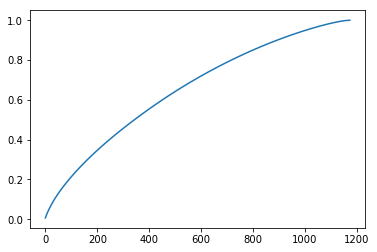

In [560]:
plt.plot(np.cumsum(lsi.projection.s/np.sum(lsi.projection.s)))
#np.argmax((np.cumsum(lsi.projection.s)/np.sum(lsi.projection.s)) > 0.8)

In [639]:
lsi_corpus = lsi[tfidf_corp]

In [640]:
V =  np.matrix([[y[1] for y in x] for x in lsi_corpus]).dot(np.linalg.inv(np.diag(lsi.projection.s)) )

In [646]:
X = lsi.projection.u.dot(np.diag(np.square(lsi.projection.s)).dot(V.T))

In [647]:
np.max(X), np.min(X), X.shape

(2.6915298563465591, -0.091368048503808474, (7372, 1176))

In [663]:

#figsize=(np.array(X.shape)/100.0)[::-1]
#plt.rcParams.update({'figure.figsize':figsize})
#fig = plt.figure(figsize=figsize)
#plt.axes([0,0,1,1]) # Make the plot occupy the whole canvas
#plt.axis('off')
#fig.set_size_inches(figsize)
# Plot the grid
#plt.imshow(np.array([[0, 0, 0],[0,0,0]]))
#plt.gray()
#plt.show()

## HDP 

In [61]:
from gensim.models import HdpModel

In [62]:
hdp = HdpModel(tfidf_corp, trigram_dictionary, T=200)
#suggested_lda.

In [63]:
suggested_lda = hdp.suggested_lda_model()

In [659]:
len(list(filter( lambda x: x, np.cumsum(sorted(suggested_lda.alpha, reverse=True)) < 0.8) ))

58

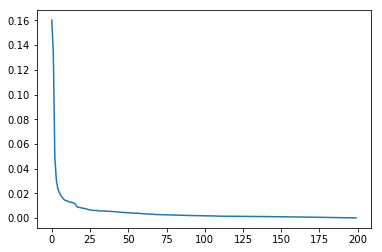

In [514]:
plt.plot((sorted(suggested_lda.alpha, reverse=True)))

In [180]:
len(list(filter(lambda x: x > 0.005, suggested_lda.alpha)))

59

In [187]:
def topic_prob_extractor(gensim_hdp):
    shown_topics = gensim_hdp.show_topics(num_topics=-1, formatted=False, num_words=40)
    topics_nos = [x[0] for x in shown_topics ]
    weights = [ sum([item[1] for item in shown_topics[topicN][1]]) for topicN in topics_nos ]

    return pd.DataFrame({'topic_id' : topics_nos, 'weight' : weights})

In [188]:
number_of_tops = topic_prob_extractor(hdp)

In [189]:
number_of_tops.sort_values('weight', ascending=False)

,topic_id,weight
18,18,0.054417
151,151,0.053892
10,10,0.053865
14,14,0.053598
1,1,0.053554
111,111,0.053227
108,108,0.053184
173,173,0.053139
198,198,0.053137
106,106,0.053077


## Topic modeling with LDA

In [518]:
%%time

#trigram_bow_corpus = MmCorpus(corpus_file_path)

#lda_model_filepath = os.path.join(corpus_path, 'lda_model')

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # workers => sets the parallelism, and should be
    # set to your number of physical cores minus one
    lda = LdaModel(tfidf_corp,
                       num_topics=28,
                       id2word=trigram_dictionary,
                       alpha = 'auto')
                       #alpha = sorted(suggested_lda.alpha, reverse=True)[:51]/sum(sorted(suggested_lda.alpha, reverse=True)[:51]), 
                       #workers=3)

CPU times: user 30.6 s, sys: 27.3 s, total: 57.9 s
Wall time: 28.2 s


In [24]:
LDAvis_data_filepath = os.path.join(corpus_path, 'ldavis_prepared')

In [519]:
%%time

LDAvis_prepared = pyLDAvis.gensim.prepare(lda, tfidf_corp, #trigram_bow_corpus,
                                              trigram_dictionary)

#with open(LDAvis_data_filepath, 'w') as f:

#    pickle.dump(LDAvis_prepared, f)


CPU times: user 7.33 s, sys: 9.39 s, total: 16.7 s
Wall time: 8.43 s


In [520]:
pyLDAvis.display(LDAvis_prepared)

In [521]:
num_mode_topics = [len(lda[doc]) for doc in tfidf_corp]

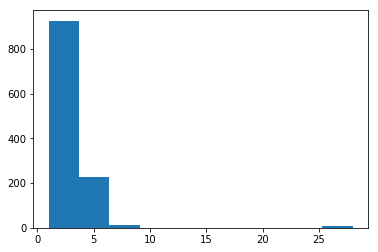

In [522]:
plt.hist(num_mode_topics);

In [251]:
sorted(suggested_lda.alpha, reverse=True)[:51]/sum(sorted(suggested_lda.alpha, reverse=True)[:51])

array([ 0.09490258,  0.06175907,  0.05506388,  0.03903014,  0.0386367 ,
        0.03305622,  0.03299535,  0.02505416,  0.02334282,  0.02305709,
        0.0225124 ,  0.02133143,  0.01969607,  0.01952011,  0.01852278,
        0.01747551,  0.01716436,  0.01713343,  0.01686427,  0.01682406,
        0.01641564,  0.0161886 ,  0.01598465,  0.01502269,  0.01462194,
        0.01444893,  0.01432202,  0.01421862,  0.01337949,  0.01327454,
        0.01327379,  0.01284483,  0.01276351,  0.01256596,  0.01214859,
        0.01207613,  0.01202885,  0.01189357,  0.01126173,  0.01118122,
        0.01106559,  0.01099497,  0.0108884 ,  0.01087787,  0.01082152,
        0.0105649 ,  0.01051136,  0.0102379 ,  0.01012177,  0.01010213,
        0.0099559 ])

In [124]:
from gensim import matutils
topics = matutils.corpus2dense(suggested_lda[tfidf_corp], num_terms=suggested_lda.num_topics)

In [125]:
from scipy.spatial import distance
pairwise = distance.squareform(distance.pdist(topics))

In [126]:
largest = pairwise.max()

for ti in range(len(topics)):
    pairwise[ti,ti] = largest+1

In [92]:
def closest_to(doc_id):
    return pairwise[doc_id].argmin()

In [127]:
lens = (topics > 0).sum(axis=0)
print(np.mean(lens))

1.51305812974


In [134]:
print(np.mean(lens <= 10))
#lda[trigram_bow_corpus[101]]
pairwise.shape

1.0


(200, 200)

In [138]:
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation().fit(pairwise)
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)

In [140]:
print(n_clusters_, cluster_centers_indices)

8 [  0   1   2   3  14  76 111 119]


In [561]:
from gensim.models import CoherenceModel

In [562]:
coherence = CoherenceModel(lda, corpus=tfidf_corp, dictionary=trigram_dictionary, coherence='u_mass')

In [563]:
coherence.get_coherence()

-2.9355130842695059

In [564]:
coherence.get_coherence_per_topic()

[-1.2476068608375741,
 -2.7316768252575363,
 -2.7143560705502781,
 -3.0897479908248608,
 -1.1368670088796813,
 -1.2974189039818231,
 -1.7696214842919693,
 -7.2831540678557731,
 -3.8910066680716144,
 -5.214811736490093,
 -2.703922171287183,
 -6.8163367121889591,
 -2.1722615409412489,
 -5.9180268194286416,
 -5.2939947041047484,
 -2.2202652546737522,
 -2.0991674174453943,
 -2.4726981384982447,
 -1.4399658930515919,
 -1.2982019816142301,
 -1.3417715976216984,
 -1.5137240391478741,
 -2.821408221924004,
 -2.0327967992265634,
 -3.7370593807069179,
 -1.9862863751624444,
 -3.2770512499746993,
 -2.6731604455067561]

In [ ]:
support_cases = pd.read_csv('./report1507007119245.csv', encoding='utf-8')
#i = 1
#with open('./report1507007119245.csv') as repfile:
#    for line in repfile:
#        if i in np.arange(16, 33):
#            print(i, line)
#        if i > 30:
#            break
#        i += 1

In [ ]:
len(support_cases)

In [481]:
#corpus_df.has_support_case[corpus_df.file.str.contains('persisting-mmc-data-on-external')] = 1 
corpus_df.has_support_case[corpus_df.file.str.contains('message-enriche')] =1 #[corpus_df.file.str.contains('setting-up-your-development-environment')] = 1


/home/kliton/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [73]:
corpus_df.loc[:, 'has_support_case'] = 0

In [482]:
len(corpus_df[corpus_df.has_support_case == 1])

196

In [55]:
len(tfidf_corp[310])

65

In [441]:
#corpus_df.to_csv('./df_flagged_extra.csv')

In [128]:
from gensim import matutils

In [130]:
matrix_corp = matutils.corpus2dense(tfidf_corp, tfidf_corp.corpus.num_terms, num_docs=tfidf_corp.corpus.num_docs)

In [134]:
matrix_corp.shape

(7372, 1176)

In [161]:
matrix_corp.shape

(7372, 1176)

In [131]:
from sklearn.decomposition import PCA

In [179]:
pcatransformer = PCA()

In [190]:
pca_matrix_corp = pcatransformer.fit_transform(matrix_corp.T)

In [193]:
eigen_vals = np.linalg.eigvalsh(pcatransformer.get_covariance())

In [200]:
idx = np.argsort(eigen_vals)[::-1]
evals = eigen_vals[idx]
variance_retained=np.cumsum(evals)/np.sum(evals)

In [467]:
evals[0], evals[7371]

(0.015456865563529936, -4.704210502745995e-18)

In [203]:
index=np.argmax(variance_retained>=0.85)

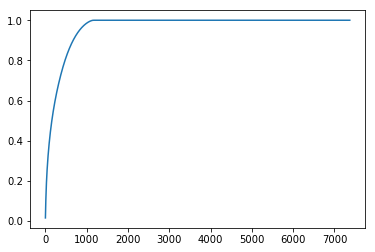

In [202]:
plt.plot(variance_retained)

In [204]:
print('Number of components retaining 85% of variance is', index)

Number of components retaining 85% of variance is 562


In [475]:
eigenvals_unsorted = np.linalg.eig(pcatransformer.get_covariance())

In [486]:
idx = np.argsort(eigenvals_unsorted[0])
idx

array([1175, 1179, 1178, ...,    2,    1,    0])

In [496]:
[trigram_dictionary[x] for x in idx[-25:]]

['cpu_memory',
 'datamapper_build',
 'war',
 'github_authentication',
 'variety',
 'grant',
 'lightweight',
 'getrecentlyadd',
 'gain',
 'lastmodifi',
 'ws_address',
 'repetition_separator',
 'tls_ssl',
 'wish_encrypt',
 '@inject',
 '------',
 'assume_familiar',
 'mitigate',
 'degree',
 'jvms',
 'subject_body',
 'value2',
 'tanuki',
 'unchecked',
 'recently']

In [205]:
pca_reduct = PCA(n_components=index)

In [207]:
corp_reducted.shape

(1176, 562)

In [537]:
corp_reducted = pca_reduct.fit_transform(matrix_corp.T)

In [208]:
corp_reducted

array([[ -2.93228621e-02,   1.06884743e-02,   3.07735361e-01, ...,
         -1.21837585e-02,  -8.27297450e-03,   1.37261196e-02],
       [  1.95937940e-01,   2.25085822e-01,   1.60195379e-02, ...,
          4.00315650e-02,   7.83236192e-03,   3.71254225e-02],
       [  1.27845318e-01,   4.14490121e-01,  -5.22015806e-02, ...,
          1.63947785e-03,  -1.47719953e-03,   1.31410759e-02],
       ..., 
       [ -4.93543941e-02,   1.09836727e-01,  -5.45422476e-02, ...,
         -1.13846515e-02,   1.36867865e-03,   2.33202429e-02],
       [ -7.55815449e-02,   1.39323333e-01,   1.94101705e-04, ...,
          6.15918187e-03,  -1.85271355e-02,  -4.81919652e-02],
       [  2.26618202e-01,   1.11414033e-01,   5.06044802e-02, ...,
          2.73297649e-02,  -7.76207403e-03,   4.02216215e-02]])

In [538]:
docs_pca = pcatransformer.fit_transform(matrix_corp)

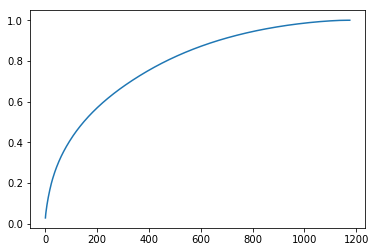

In [541]:
plt.plot(np.cumsum(pcatransformer.explained_variance_ratio_))

In [544]:
np.argmax(np.cumsum(pcatransformer.explained_variance_ratio_)>=0.85)

556

In [209]:

# regex to remove links
link_comp_num = re.compile(r"link:.*?\[(\w*)\]*?")
    
# regex to remove images
image_comp_num =re.compile(r"image:.*?\[(\w([\s.-])*)*\]*?")
    
image_regex_num = r"image:.*\[((\w(\s\S)*)*)\]"
    
# regex to remove code
codeblock_comp_num = re.compile(r"\n\[(\w[,-.\s]*)+\]\n----.*?----", flags=re.S)


In [219]:
# Add other features to the dataframe

corpus_df.loc[:,'no_images'] = corpus_df.text.apply(lambda x: len(image_comp_num.findall(x)))
corpus_df.loc[:,'no_links'] = corpus_df.text.apply(lambda x: len(link_comp_num.findall(x)))
corpus_df.loc[:, 'no_codeblock'] = corpus_df.text.apply(lambda x: len(codeblock_comp_num.findall(x)))

In [442]:
#np.save('./corp_reducted.dmp', corp_reducted)
#np.save('./corp_reducted_ex.dmp', corp_red_ex)